# 基于经典网络架构训练图像分类模型

### torchvision中常用的功能
- dataset 包括常用的数据集合数据存放规则（DatasetFolder）
- models 包括经典网络架构 AlexNet\VGG\ResNet 以及预训练模型（权重和偏置参数）→迁移学习
- transforms 对图像数据的预处理

### 数据预处理部分：

- 数据增强：torchvision中transforms模块自带功能，比较实用
- 数据预处理：torchvision中transforms也帮我们实现好了，直接调用即可
- DataLoader模块直接读取batch数据

### 网络模块设置：

- 加载预训练模型，torchvision中有很多经典网络架构，调用起来十分方便，并且可以用人家训练好的权重参数来继续训练，也就是所谓的迁移学习
- 需要注意的是别人训练好的任务跟当前的的不是完全一样，需要把最后的head层改一改，一般也就是最后的全连接层，改成自己的任务
- 训练时可以全部重头训练，也可以只训练最后咱们任务的层，因为前几层都是做特征提取的，本质任务目标是一致的

### 网络模型保存与测试
- 模型保存的时候可以带有选择性，例如在验证集中如果当前效果好则保存
- 读取模型进行实际测试

In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
#pip install torchvision
from torchvision import transforms, models, datasets
#https://pytorch.org/docs/stable/torchvision/index.html
import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image

# 下面是一个花花❀分类任务的演示

### 数据读取

In [2]:
#数据集存放的位置
#训练集和测试集中，不同编号的文件夹下储存了不同编号的花代表不同种类
#这种数据存储方法是torchvision中一种非常标准的方法
#该示例是一个102分类的任务
data_dir = './flower_data/'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

### 数据预处理操作
- data_transforms中指定了所有图像预处理操作  
  什么是数据增强？数据量在深度学习中非常重要
  当原始输入数据不够的时候，要能够自动生成更多的数据。比如翻转、旋转、裁剪、缩放操作等等
- ImageFolder假设所有的文件按文件夹保存好，每个文件夹下面存贮同一类别的图片，文件夹的名字为分类的名字


In [3]:
#这里就是在训练集中进行数据增强中的各个操作
#各种操作的随机化与组合
data_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(45),#随机旋转，-45到45度之间随机选
        transforms.CenterCrop(224),#从中心开始裁剪 对不同大小的数据要先进行一个resize操作，比如256*256、224*224（VGG和Resnet的要求）
        transforms.RandomHorizontalFlip(p=0.5),#随机水平翻转 选择一个概率概率
        transforms.RandomVerticalFlip(p=0.5),#随机垂直翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),#参数1为亮度，参数2为对比度，参数3为饱和度，参数4为色相
        transforms.RandomGrayscale(p=0.025),#概率转换成灰度率，3通道就是R=G=B
        transforms.ToTensor(),  #把之前所有的数据转换成Tensor格式
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#均值，标准差   #迁移学习，同样需要遵循减均值除标准差的操作（与预训练结果要一致）
    ]),
#在测试集中不再需要进行数据增强
#但预处理操作需要保持一致
    'valid': transforms.Compose([transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
batch_size = 1
#根据显存决定batch_size的大小
#大任务要用GPU跑...硬件真是一窍不通orz
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']} #传入的参数数据位置和预处理操作是
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']} #传入数据集，构建一个一个batch的训练数据
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

#### 输出效果演示

In [5]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 6552
     Root location: ./flower_data/train
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
                CenterCrop(size=(224, 224))
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ColorJitter(brightness=[0.8, 1.2], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
                RandomGrayscale(p=0.025)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 818
     Root location: ./flower_data/valid
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456,

In [6]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1db80382b80>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x1db80382ca0>}

In [7]:
dataset_sizes

{'train': 6552, 'valid': 818}

### 读取标签对应的实际名字

In [8]:
#json文件给出了每一种花对应的花名
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

#### 类别演示

In [9]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

#### 数据演示
- 注意tensor的数据需要转换成numpy的格式，而且还需要还原回标准化的结果

In [10]:
def im_convert(tensor):
    """ 展示数据"""
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0) #torch中c dimension是第一个
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

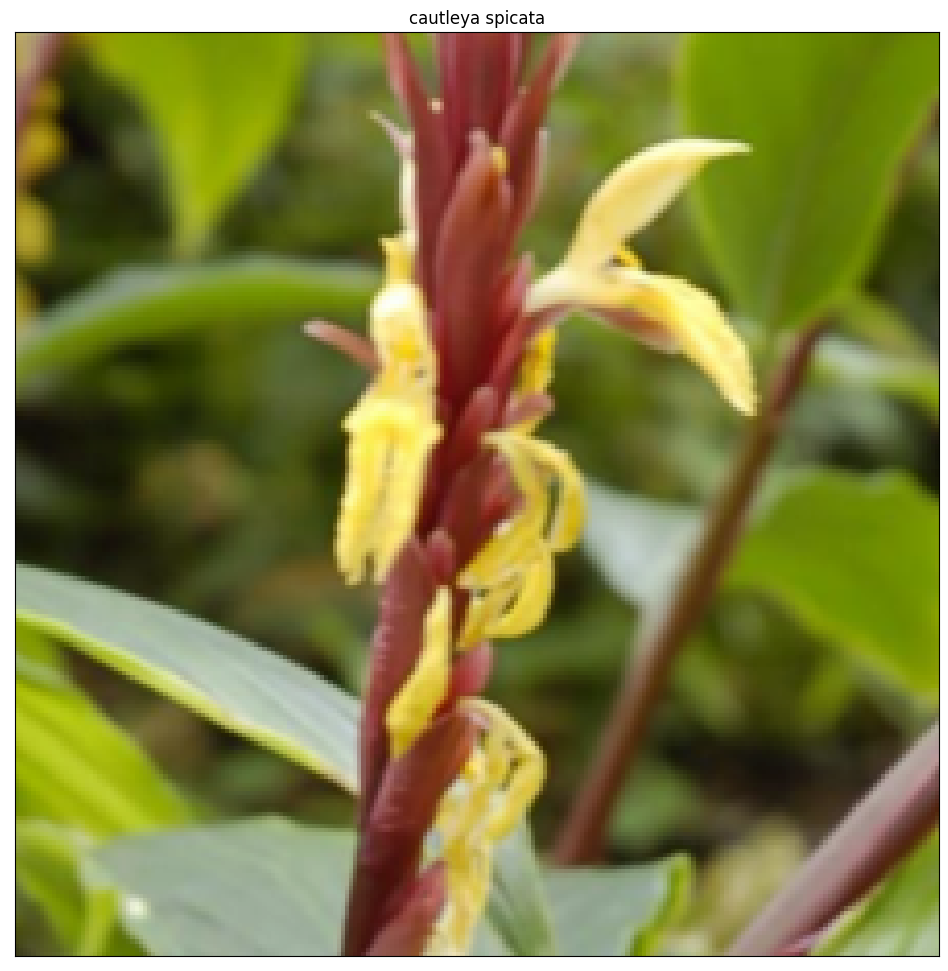

In [11]:
fig=plt.figure(figsize=(20, 12))
columns = 1
rows = 1

dataiter = iter(dataloaders['valid'])
inputs, classes = dataiter.next()

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(cat_to_name[str(int(class_names[classes[idx]]))])
    plt.imshow(im_convert(inputs[idx]))
plt.show()

### 加载models中提供的模型，并且直接用训练的好权重当做初始化参数  迁移学习！
- 为了解决训练数据有限、训练时间长等问题，可以用已训练过的已有模型的参数
- 哪些参数是可以直接迁移过来的？
  将卷积层特征当做权重参数初始化并继续训练更新（A路径）/直接使用这些参数作为训练结果（B路径）/两者结合，部分固定部分
  但一般而言全连接层需要按自己的数据重新训练（比如筛选类别、名称、特征一般都不同）
  数据量较小的时候对已训练结果依赖较强

In [12]:
#第一次执行需要下载，下载好的可以直接放到相应路径
model_name = 'resnet'  #可选的比较多 ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception']
#是否用人家训练好的特征来做
feature_extract = True 

In [13]:
# 是否用GPU训练
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is not available.  Training on CPU ...


In [14]:
#指定哪些层被冻住
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

#### 设置模型层数与模型具体内容
- 注意修改最后一行全连接层的分类数

In [15]:
model_ft = models.resnet152()
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 参考pytorch官网例子-设置不同模型的输入

In [16]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # 选择合适的模型，不同模型的初始化方法稍微有点区别
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet152
        """
        #可以选择要用多少层的模型
        model_ft = models.resnet152(pretrained=use_pretrained)  #传递是否加载预训练模型的参数
        set_parameter_requires_grad(model_ft, feature_extract)  #指定迁移学习中哪些层需要固定
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 102),    #修改最后全连接层的分类数
                                   nn.LogSoftmax(dim=1))
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

### 训练准备

In [17]:
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)

#GPU计算
model_ft = model_ft.to(device)

# 模型保存
filename='checkpoint.pth'

# 是否训练所有层
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 fc.0.weight
	 fc.0.bias


In [18]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 优化器设置

In [19]:
# 优化器设置
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)#学习率每7个epoch衰减成原来的1/10
#最后一层已经LogSoftmax()了，所以不能nn.CrossEntropyLoss()来计算了，nn.CrossEntropyLoss()相当于logSoftmax()和nn.NLLLoss()整合
criterion = nn.NLLLoss()  #损失函数的定义

### 训练模块

In [20]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False,filename=filename):
    since = time.time()
    best_acc = 0   #记录准确率，保存准确率最好的模型
    """
    checkpoint = torch.load(filename)
    best_acc = checkpoint['best_acc']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.class_to_idx = checkpoint['mapping']
    """
    model.to(device)

    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]

    best_model_wts = copy.deepcopy(model.state_dict())  #保存准确率最好的模型

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 训练
            else:
                model.eval()   # 验证

            running_loss = 0.0
            running_corrects = 0

            # 把数据都取个遍
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:#resnet执行的是这里
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # 训练阶段更新权重
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            
            time_elapsed = time.time() - since
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            # 得到最好那次的模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                  'state_dict': model.state_dict(),
                  'best_acc': best_acc,
                  'optimizer' : optimizer.state_dict(),
                }
                torch.save(state, filename)
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                scheduler.step(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
        
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 训练完后用最好的一次当做模型最终的结果
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs 

### 开始训练！

In [ ]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=5, is_inception=(model_name=="inception"))

Epoch 0/4
----------


C:\Users\26253\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### 再继续训练所有层

In [ ]:
for param in model_ft.parameters():
    param.requires_grad = True

# 再继续训练所有的参数，学习率调小一点
optimizer = optim.Adam(params_to_update, lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 损失函数
criterion = nn.NLLLoss()

In [ ]:
# Load the checkpoint

checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
#model_ft.class_to_idx = checkpoint['mapping']

In [ ]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer, num_epochs=10, is_inception=(model_name=="inception"))

### 测试网络效果

输入一张测试图像，看看网络的返回结果：

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

注意预处理方法需相同

### 加载训练好的模型

In [ ]:
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)

# GPU模式
model_ft = model_ft.to(device)

# 保存文件的名字
filename='seriouscheckpoint.pth'

# 加载模型
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

### 测试数据预处理

- 测试数据处理方法需要跟训练时一直才可以 
- crop操作的目的是保证输入的大小是一致的
- 标准化操作也是必须的，用跟训练数据相同的mean和std,但是需要注意一点训练数据是在0-1上进行标准化，所以测试数据也需要先归一化
- 最后一点，PyTorch中颜色通道是第一个维度，跟很多工具包都不一样，需要转换


In [ ]:
def process_image(image_path):
    # 读取测试数据
    img = Image.open(image_path)
    # Resize,thumbnail方法只能进行缩小，所以进行了判断
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop操作
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # 相同的预处理方法
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # 注意颜色通道应该放在第一个位置
    img = img.transpose((2, 0, 1))
    
    return img

In [ ]:
def imshow(image, ax=None, title=None):
    """展示数据"""
    if ax is None:
        fig, ax = plt.subplots()
    
    # 颜色通道还原
    image = np.array(image).transpose((1, 2, 0))
    
    # 预处理还原
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    ax.set_title(title)
    
    return ax

In [ ]:
image_path = 'image_06621.jpg'
img = process_image(image_path)
imshow(img)

In [ ]:
img.shape

In [ ]:
# 得到一个batch的测试数据
dataiter = iter(dataloaders['valid'])
images, labels = dataiter.next()

model_ft.eval()

if train_on_gpu:
    output = model_ft(images.cuda())
else:
    output = model_ft(images)

output表示对一个batch中每一个数据得到其属于各个类别的可能性

In [ ]:
output.shape

### 得到概率最大的那个

In [ ]:
_, preds_tensor = torch.max(output, 1)

preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
preds

### 展示预测结果

In [ ]:
fig=plt.figure(figsize=(20, 20))
columns =4
rows = 2

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(cat_to_name[str(preds[idx])], cat_to_name[str(labels[idx].item())]),
                 color=("green" if cat_to_name[str(preds[idx])]==cat_to_name[str(labels[idx].item())] else "red"))
plt.show()